In [35]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image

n_power = 0.0
dm_mass = 1 #GeV
step_size_cross_section = 2e-26 #* pow(dm_mass,0.15)

In [36]:
list_param = ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff']
list_fiducial = [0.02222, 0.1197,      0.69,  2.1955e-9, 0.9655, 0.06, 0]
list_step = [0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))
#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 
#6e-13 * pow(dm_mass,1.25) <- n=4
Tcmb = 2.726

In [38]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl,',
    'l_max_scalars': 2500,
    'omega_b': list_fiducial[0],
    'omega_dmeff': list_fiducial[1],
    'h': list_fiducial[2],
    'A_s' : list_fiducial[3],
    'n_s' : list_fiducial[4], 
    'tau_reio' : list_fiducial[5],
    'sigma_dmeff': list_fiducial[6],
    'm_dmeff': dm_mass,
    'omega_cdm' : 1.0e-10,
    'npow_dmeff': n_power
}

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']

In [39]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [167]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmeff':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

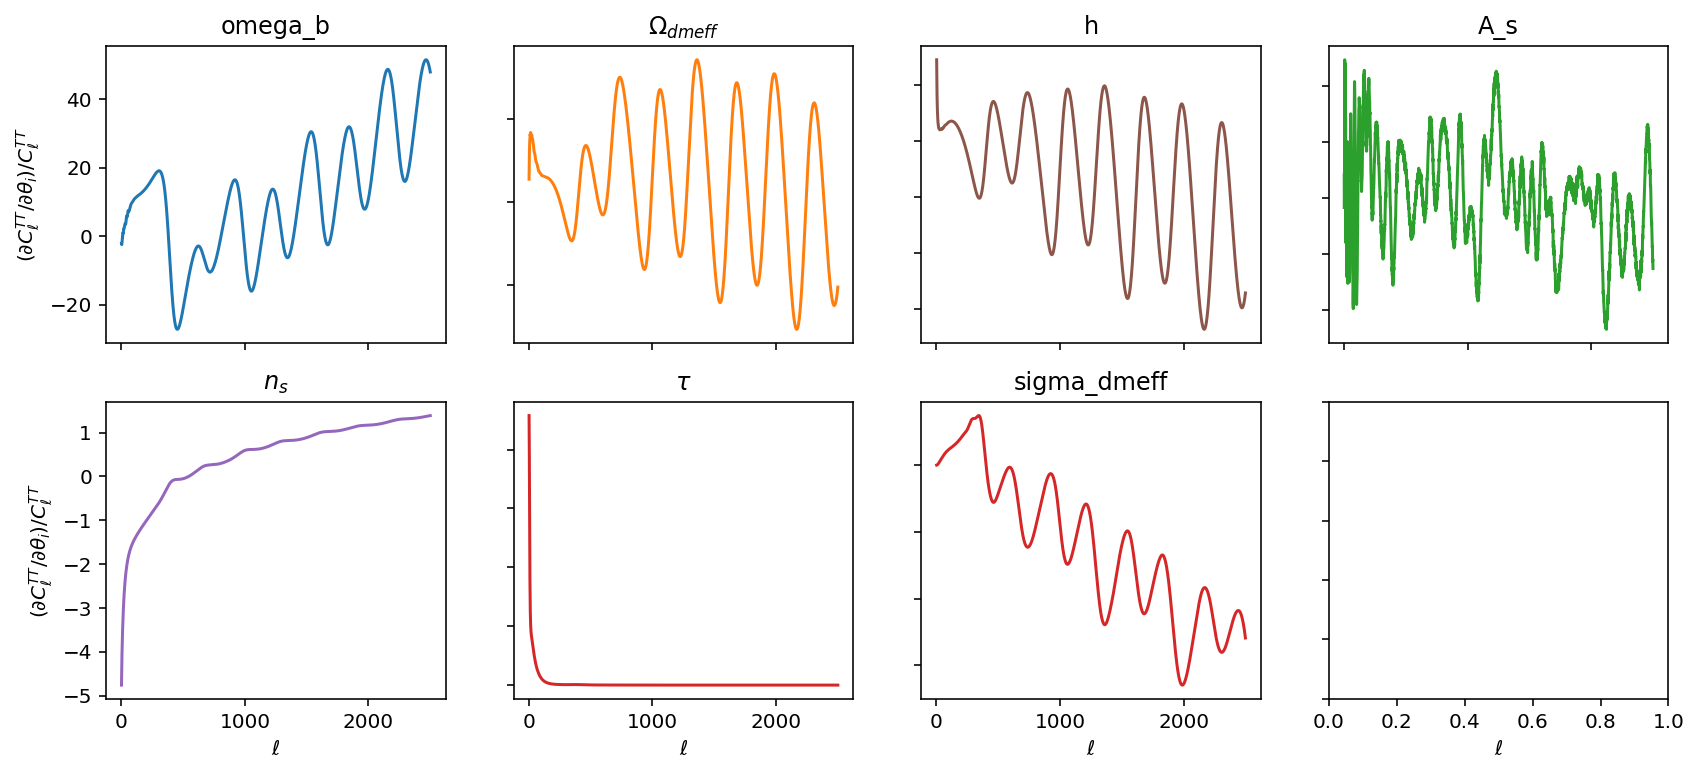

In [21]:
'''fig, axs = plt.subplots(2, 4, figsize=(14,6))
axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')
axs[0, 1].plot(dict_norm_der['omega_dmeff'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmeff}$')
axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')
axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')
axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')
axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')
axs[1, 2].plot(dict_norm_der['sigma_dmeff'], 'tab:red')
axs[1, 2].set_title('sigma_dmeff')
for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer() 
#fig.savefig("fisher_plots/derivative_C_l_TT_0.01GeV_n=2.png")
'''

In [173]:
sT = (33. * (np.pi/60./180. ))/(1.0e6*Tcmb)
sP = (56. * (np.pi/60./180. ))/(1.0e6*Tcmb)
f_sky = 0.65
theta_fwhm = 7. * (np.pi/60./180.)

l_min = 2
l_max = 2500

from scipy.special import expit

N_TT = np.zeros(l_max+1, 'float64')
N_EE = np.zeros(l_max+1, 'float64')

for l in range(l_min , l_max+1):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_TT[ell < l_min] = 1e100
N_TT[ell > l_max] = 1e100
N_EE[ell < l_min] = 1e100
N_EE[ell > l_max] = 1e100

In [174]:
#reading each line from file and replacing "-" by ","
data = np.loadtxt("noise/planck_noise_k_fishchips.txt", delimiter = " ")
N_KK = data[:,3]
N_TTtest = data[:,1]
N_EEtest = data[:,2]

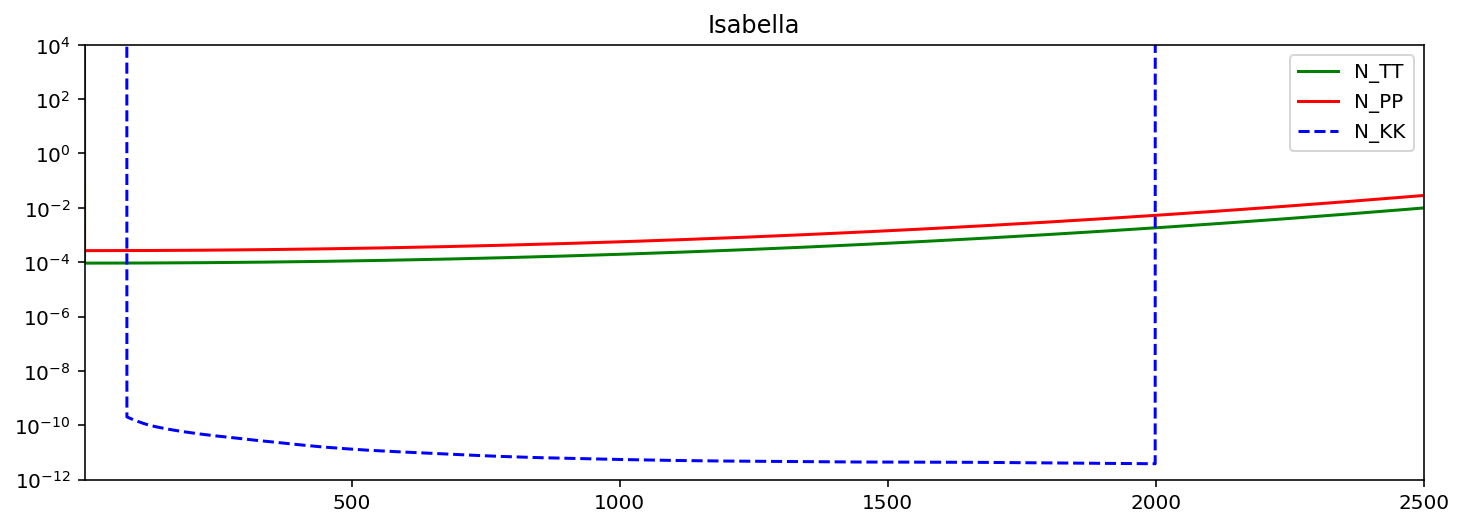

In [176]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(N_TT *(1.0e6*Tcmb)**2, 'g-',label="N_TT")
plt.plot(N_EE *(1.0e6*Tcmb)**2, 'r-',label="N_PP")
#plt.plot(N_TTtest , 'g--',label="N_TT fishchips")
#plt.plot(N_EEtest , 'r--',label="N_EE fishchips")
plt.plot(N_KK , 'b--',label="N_KK")
plt.yscale('log')
plt.ylim(1e-12,1e4)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Isabella')
#fig.savefig("fisher_plots/noise from fishchips vs txt file")
plt.show()

In [189]:
Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i]/(Tcmb*1e6)**2)
        
Cl_kk = np.array(Cl_est_kk)

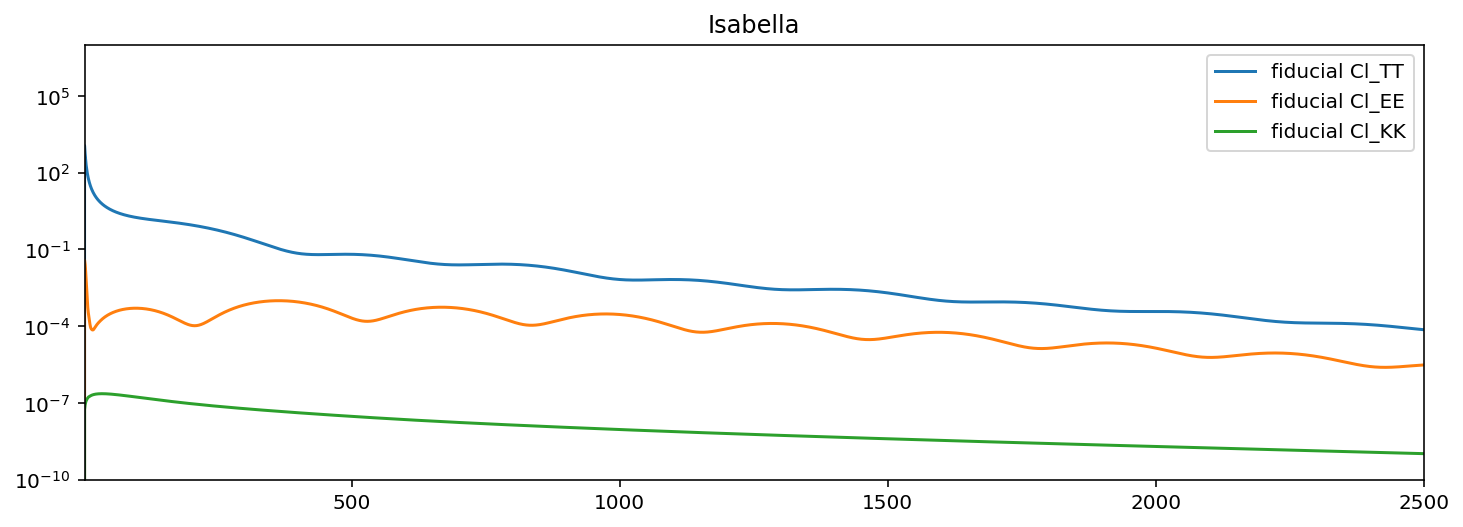

In [192]:
#Plotting Cl's
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(fiducial['tt'] * (Tcmb*1e6)**2, '-',label="fiducial Cl_TT")
plt.plot(fiducial['ee'] * (Tcmb*1e6)**2, '-',label="fiducial Cl_EE")
plt.plot(Cl_kk  * (Tcmb*1e6)**2, '-',label="fiducial Cl_KK")
plt.yscale('log')
plt.ylim(1e-10,1e7)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Isabella')
plt.show()

In [179]:
dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

def factorial(n):
    fact = 1
    for i in range(1,n+1): 
        fact = fact * i 
    return fact

dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append(1.0/4 * (factorial(l+2)/factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)
    
#print(dC_lkk)

<ipython-input-167-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [181]:
# 2x2 matrix or 3x3 depending on kk
#MAT_d_cl = [ [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial)]
#            , [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial)] ]

#MAT_cl = [ [fiducial['tt'] + N_TT, fiducial['te']], 
#            [fiducial['te'], fiducial['ee'] +N_EE] ]

MAT_d_cl = [[compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial), 0],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial), 0],
            [0, 0, dC_lkk]]
    
MAT_cl = [ [fiducial['tt'] + N_TT, fiducial['te'], 0], 
           [fiducial['te'], fiducial['ee'] + N_EE, 0],
           [0, 0,  Cl_kk + N_KK] ]

<ipython-input-167-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [185]:
#for i in list_param:
def compute_Q_i(i, l):
    #d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l]], [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l]]]
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l], 0], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l], 0],
              [0, 0, MAT_d_cl[2][2][i][l]]]
    
    #cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l]], [MAT_cl[1][0][l], MAT_cl[1][1][l]]]
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l], 0],
          [MAT_cl[1][0][l], MAT_cl[1][1][l], 0],
          [0, 0, MAT_cl[2][2][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [186]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)

In [187]:
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 9.970180179718881e-05
omega_dmeff 0.0004131959857893491
h 0.0020062713156507248
A_s 1.4250392797257022e-11
n_s 0.002419443368827406
tau_reio 0.003683448839684024
sigma_dmeff 4.01508551400885e-27


In [ ]:
covar

In [30]:
covar

array([[ 2.13746827e-08, -8.06184313e-08,  6.30539231e-07,
         3.23418302e-16,  4.75945450e-07,  7.11451627e-08,
         1.32908072e-29],
       [-8.06184313e-08,  1.95656007e-06, -7.24137418e-06,
         1.05539155e-14, -9.24028359e-07, -5.31857577e-07,
         1.06601396e-28],
       [ 6.30539231e-07, -7.24137418e-06,  3.54243684e-05,
        -1.80015651e-14,  1.84995104e-05,  3.45096486e-06,
         1.54229185e-28],
       [ 3.23418302e-16,  1.05539155e-14, -1.80015651e-14,
         3.88333845e-22,  3.44009733e-14,  6.20836248e-14,
         2.10166730e-36],
       [ 4.75945450e-07, -9.24028359e-07,  1.84995104e-05,
         3.44009733e-14,  3.91504709e-05,  3.84212470e-06,
         1.15710147e-27],
       [ 7.11451627e-08, -5.31857577e-07,  3.45096486e-06,
         6.20836248e-14,  3.84212470e-06,  1.44483778e-05,
         8.25922719e-29],
       [ 1.32908072e-29,  1.06601396e-28,  1.54229185e-28,
         2.10166730e-36,  1.15710147e-27,  8.25922719e-29,
         4.9171045

In [1]:
#file = open("sigma_dmeff.txt", "w")
#print("sigma_dmeff","dm_mass [GeV]", sigma_ii*2.48 ,file=file)
#print(sigma_ii, dm_mass,file=file)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [ ]:
#print(dm_mass, sigma_ii*2.48)

In [ ]:
import fishchips.util

cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);

#fig.savefig("fisher_plots/triagular_ellipses_0.001GeV_n=2.png")
cov

In [ ]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48)

In [ ]:
print(dat)

In [177]:
#outF = open("fisher_data/planck_n=2/0.01GeV.txt", "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()